In [1]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from melp import Detector
import melp
import math

from melp.clustering.misc import*
import melp.clustering as clump
import melp.clustering.time_cluster as tclump
#from melp import TileAnalyzer
import melp.clustering.spatial_cluster as sclump
import melp.clustering.plots as clump_plt

plt.rcParams.update({'font.size': 16})

Welcome to JupyROOT 6.24/06


#### Load files

In [2]:
filename_trirec = "./testdata/trirec/trirec1.root"
filename_sorted = "./testdata/sorted/sorted1.root"

file = ROOT.TFile(filename_sorted)
ttree_mu3e = file.Get("mu3e")
ttree_mu3e_mc = file.Get("mu3e_mchits")

file_rec = ROOT.TFile(filename_trirec)
ttree_trirec = file_rec.Get("frames")
ttree_trirec_mc = file_rec.Get("frames_mc")
ttree_mu3e_segs = file_rec.Get("segs")

In [3]:
frame = 1
ttree_trirec.GetEntry(frame)
ttree_trirec_mc.GetEntry(frame)

ttree_mu3e.GetEntry(frame)
ttree_mu3e_mc.GetEntry(frame)
   
tid_rec = ttree_trirec.mc_tid
tid_rec_mc = ttree_trirec_mc.mc_tid

tid_counter = 0
for i in tid_rec_mc:
    if i in get_tid_frame(ttree_mu3e, ttree_mu3e_mc).values():
        tid_counter += 1
    else:
        continue

print(tid_counter/(len(get_tid_frame(ttree_mu3e, ttree_mu3e_mc))/100), "%")
print(len(tid_rec_mc)/(len(tid_rec)/100), "%")

10.526315789473685 %
70.0 %


In [4]:
ttree_mu3e_segs.GetEntry(frame)

segs_rec_tid = ttree_mu3e_segs.tl_n

In [5]:
print(segs_rec_tid)

print(tid_rec)

0
{ 28341, 33517, 32299, 34367, 37051, 16492, 16492, 16492, 25876, 25876 }


#### Whole frame as cluster

In [6]:
eff_counter = 0
tot_hit_counter = 0
wrong_counter = 0

eff_counter_arr = []
tot_hit_counter_arr = []
wrong_counter_arr = []

for frame in range(ttree_mu3e.GetEntries()):
    ttree_mu3e.GetEntry(frame)
    tmp_eff_counter = 0
    tmp_tot_hit_counter = 0
    tmp_wrong_counter = 0
    
    primaries = get_mc_primary_for_hit_frame(ttree_mu3e)
    cluster = frame_as_cluster(ttree_mu3e)
    tot_hit_counter += len(cluster)
    tmp_tot_hit_counter += len(cluster)
    for key in cluster.keys():
        if key in primaries.keys():
            if cluster[key] == primaries[key]:
                eff_counter += 1
                tmp_eff_counter += 1
            else:
                wrong_counter += 1
                tmp_wrong_counter += 1
        else:
            continue
        eff_counter_arr.append(tmp_eff_counter)
        tot_hit_counter_arr.append(tmp_tot_hit_counter)
        wrong_counter_arr.append(tmp_wrong_counter)
             
print("Average number of hits per frame: ", tot_hit_counter/ttree_mu3e.GetEntries())
print("Correctly identified: ", eff_counter/(tot_hit_counter/100), "%")
print("Incorrectly identified (not an actual part of cluster): ", wrong_counter/(tot_hit_counter/100), "%")
print("Not identified (actual part of cluster that hasn't been identified): ", 0, "%")

Average number of hits per frame:  15.50653983353151
Correctly identified:  17.345295606165173 %
Incorrectly identified (not an actual part of cluster):  82.65470439383483 %
Not identified (actual part of cluster that hasn't been identified):  0 %


In [7]:
"""
plt.figure(figsize=(18,10))
plt.hist(tot_hit_counter_arr)
plt.hist(wrong_counter_arr)
plt.hist(eff_counter_arr)
plt.show()
"""

'\nplt.figure(figsize=(18,10))\nplt.hist(tot_hit_counter_arr)\nplt.hist(wrong_counter_arr)\nplt.hist(eff_counter_arr)\nplt.show()\n'

In [8]:
"""
plt.figure(figsize=(18,10))
plt.hist(eff_counter_arr + wrong_counter_arr)
plt.show()
"""

'\nplt.figure(figsize=(18,10))\nplt.hist(eff_counter_arr + wrong_counter_arr)\nplt.show()\n'

#### Masks (Small. Medium, Big)

In [9]:
mu3e_detector = Detector.initFromROOT("./testdata/sorted/sorted1.root")
#mu3e_detector = Detector.initFromSave("test_detector_file")

------------------------------
Detector information

Stats:
  - Tiles:  5824
    -> misal:  False
  - Pixel Modules:  2844
  - Loaded Runs (Tiles):  []
  - Loaded Runs (Pixel):  []
------------------------------


In [10]:
#mu3e_detector.save("test_detector_file")

In [11]:
melp.select(mu3e_detector)
print(mu3e_detector)

Detector(TileDetector=<melp.src.tile.TileDetector object at 0x7f4fccadc940>, SensorModules=<melp.src.sensor.SensorModule object at 0x7f4fcac6f700>))


In [12]:
melp.addTileHits("./testdata/sorted/sorted1.root", truth=False, traj=False)
mu3e_detector.info()

------------------------------
Detector information

Stats:
  - Tiles:  5824
    -> misal:  False
  - Pixel Modules:  2844
  - Loaded Runs (Tiles):  [1]
  - Loaded Runs (Pixel):  []
------------------------------


In [13]:
#select frame to analyze
frame_used = 1
ttree_mu3e.GetEntry(frame_used)

#build masks (and deconstruct them into arrays)
#masks = sclump.build_mask_detector_class(filename_sorted, frame_used, mu3e_detector, mask_type = "big")
masks = sclump.build_mask_around_cluster_primary(ttree_mu3e, ttree_mu3e_mc, mu3e_detector, mask_type = "big")

keys = []
values = []
for key in masks.keys():
    keys.append(key)
    values.append(masks[key])
    
#mu3e_detector.TileDetector.tile[keys[0]].id
#mu3e_detector.TileDetector.tile[keys[0]].hits
#print(values[0])

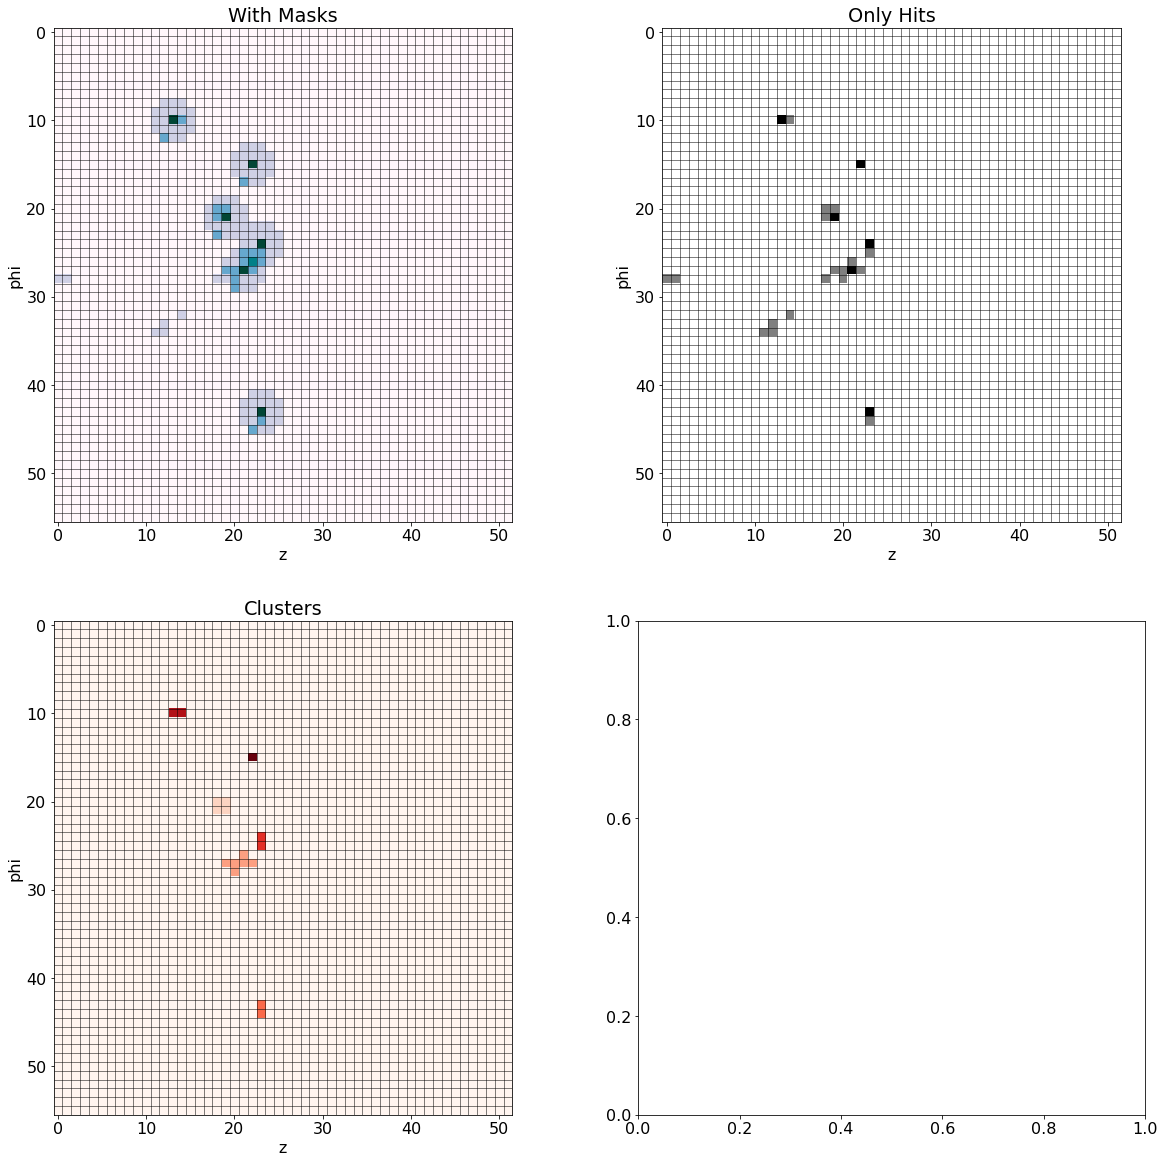

In [14]:
grid = np.zeros((52,56))

#Choose if a single hit is plotted of all hits in frame (True, False)
all_hits = True

#If single hit is chosen. Choose hit to plot
single_hit = 1

#add hits in frame
if all_hits == True:
    for tile_id in mu3e_detector.TileDetector.tile:
        if tile_id < 300000:
            tile = mu3e_detector.TileDetector.tile[tile_id]
            for hits in tile.hits:
                if hits.frame_id in [frame_used]:
                    x = tile.row()
                    y = tile.column()
                    grid[x][y] += 1

#add masks
if all_hits == True:
    for i in range(len(values)):
        for mask_tile in values[i]:
            tile = mu3e_detector.TileDetector.tile[mask_tile]
            if mask_tile < 300000:
                x = tile.row()
                y = tile.column()
                grid[x][y] += 1

        #add centre a second and third time      
        if keys[i] < 300000:
            tile = mu3e_detector.TileDetector.tile[keys[i]]
            x = tile.row()
            y = tile.column()
            grid[x][y] += 2
                     
if all_hits == False:
    for mask_tile in values[single_hit]:
        tile = mu3e_detector.TileDetector.tile[mask_tile]
        if mask_tile < 300000:
            x = tile.row()
            y = tile.column()
            grid[x][y] += 1

    #add centre a second and third time      
    if keys[single_hit] < 300000:
        tile = mu3e_detector.TileDetector.tile[keys[single_hit]]
        x = tile.row()
        y = tile.column()
        grid[x][y] += 2
                
fig, ax = plt.subplots(2,2, figsize=(20,20))
#heatplot_mask = ax.imshow(mask_grid.T, cmap='binary')
heatplot = ax[0,0].imshow(grid.T, cmap='PuBuGn')
#ax.grid(which='minor', color='b', linestyle='-', linewidth=1)
ax[0,0].hlines(y=np.arange(0, 56)+0.5, xmin=-0.5, xmax=51.5, color="black", linewidth = 0.5)
ax[0,0].vlines(x=np.arange(0, 52)+0.5, ymin=-0.5, ymax=55.5, color="black", linewidth = 0.5)
ax[0,0].set_title("With Masks")
ax[0,0].set_xlabel("z")
ax[0,0].set_ylabel("phi")


#plot reference
ref_grid = np.zeros((52,56))
for tile_id in mu3e_detector.TileDetector.tile:
    if tile_id < 300000:
        tile = mu3e_detector.TileDetector.tile[tile_id]
        for hits in tile.hits:
            if hits.frame_id in [frame_used]:
                x = tile.row()
                y = tile.column()
                ref_grid[x][y] += 1
                
#plot primary hits into reference plot(truth)
cluster_primary = get_cluster_primary_truth_frame(ttree_mu3e, ttree_mu3e_mc)  
    
for i in range(len(cluster_primary)):
    primary = mu3e_detector.TileDetector.tile[cluster_primary[i]]
    if primary.id < 300000:
        x = primary.row()
        y = primary.column()
        ref_grid[x][y] += 1
                
                
heatplot = ax[0,1].imshow(ref_grid.T, cmap='binary')
#ax.grid(which='minor', color='b', linestyle='-', linewidth=1)
ax[0,1].hlines(y=np.arange(0, 56)+0.5, xmin=-0.5, xmax=51.5, color="black", linewidth = 0.5)
ax[0,1].vlines(x=np.arange(0, 52)+0.5, ymin=-0.5, ymax=55.5, color="black", linewidth = 0.5)
ax[0,1].set_title("Only Hits")
ax[0,1].set_xlabel("z")
ax[0,1].set_ylabel("phi")


#plot clusters
cluster_grid = np.zeros((52,56))
clusters = sclump.build_clusters_in_masks(ttree_mu3e, ttree_mu3e_mc, mu3e_detector, mask_type = "big")
cluster_primaries = []
whole_clusters = []
for key in clusters.keys():
    cluster_primaries.append(key)
    whole_clusters.append(clusters[key])

color_clusters = 1
for i in range(len(clusters)):
    color_clusters += 1
    for cluster_tile in whole_clusters[i]:
        tile = mu3e_detector.TileDetector.tile[cluster_tile]
        if cluster_tile < 300000:
            x = tile.row()
            y = tile.column()
            cluster_grid[x][y] += i+1

    #add centre    
    if cluster_primaries[i] < 300000:
        tile = mu3e_detector.TileDetector.tile[cluster_primaries[i]]
        x = tile.row()
        y = tile.column()
        cluster_grid[x][y] += i+1
    
    
heatplot = ax[1,0].imshow(cluster_grid.T, cmap='Reds')
#ax.grid(which='minor', color='b', linestyle='-', linewidth=1)
ax[1,0].hlines(y=np.arange(0, 56)+0.5, xmin=-0.5, xmax=51.5, color="black", linewidth = 0.5)
ax[1,0].vlines(x=np.arange(0, 52)+0.5, ymin=-0.5, ymax=55.5, color="black", linewidth = 0.5)
ax[1,0].set_title("Clusters")
ax[1,0].set_xlabel("z")
ax[1,0].set_ylabel("phi")
#plt.savefig("hitmap.png")
plt.show()

## Efficiency Plots

#### Hits not included in any cluster

#### Hits associated to wrong cluster

#### Hits correctly associated

In [15]:
frac_corr_frame, frac_uncorr_frame = clump_plt.compare_to_primary(ttree_mu3e, ttree_mu3e_mc, mu3e_detector, mask_type = "big")

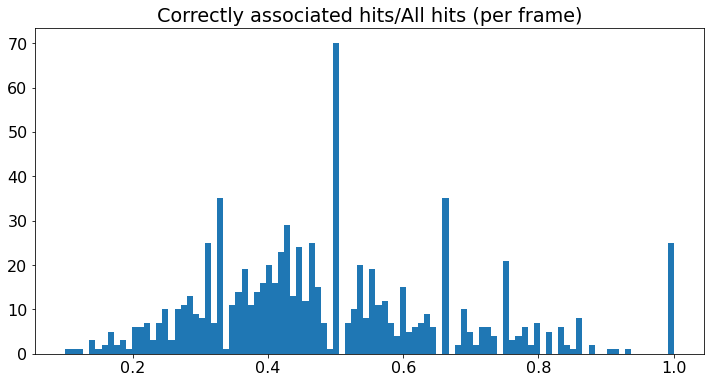

In [16]:
fig = plt.figure(figsize=(12,6))
plt.hist(frac_corr_frame, bins = 100)
plt.title("Correctly associated hits/All hits (per frame)")
plt.show()